In [8]:
# This notebook walks through the process of conducting PCA and PCR 
# using the mtcars data. PCA will be conducted from scratch and 
# from the sklearn PCA library.   

# Import necessary Python libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import scale # center to the mean and component wise scale to unit variance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [15]:
# Read in the mtcars data
df = pd.read_csv('Data/mtcars.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 12 columns):
model    32 non-null object
mpg      32 non-null float64
cyl      32 non-null int64
disp     32 non-null float64
hp       32 non-null int64
drat     32 non-null float64
wt       32 non-null float64
qsec     32 non-null float64
vs       32 non-null int64
am       32 non-null int64
gear     32 non-null int64
carb     32 non-null int64
dtypes: float64(5), int64(6), object(1)
memory usage: 3.2+ KB


In [21]:
# Remove the model names from df and set to data matrix, X
models = np.asarray(df['model'])
X = df.drop(['model'], axis=1).astype(float)
X

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6.0,160.0,110.0,3.90,2.620,16.46,0.0,1.0,4.0,4.0
1,21.0,6.0,160.0,110.0,3.90,2.875,17.02,0.0,1.0,4.0,4.0
2,22.8,4.0,108.0,93.0,3.85,2.320,18.61,1.0,1.0,4.0,1.0
3,21.4,6.0,258.0,110.0,3.08,3.215,19.44,1.0,0.0,3.0,1.0
4,18.7,8.0,360.0,175.0,3.15,3.440,17.02,0.0,0.0,3.0,2.0
5,18.1,6.0,225.0,105.0,2.76,3.460,20.22,1.0,0.0,3.0,1.0
6,14.3,8.0,360.0,245.0,3.21,3.570,15.84,0.0,0.0,3.0,4.0
7,24.4,4.0,146.7,62.0,3.69,3.190,20.00,1.0,0.0,4.0,2.0
8,22.8,4.0,140.8,95.0,3.92,3.150,22.90,1.0,0.0,4.0,2.0
9,19.2,6.0,167.6,123.0,3.92,3.440,18.30,1.0,0.0,4.0,4.0


In [24]:
def run_PCA(X):
    """
    Runs PCA from scratch with X being a nxm data matrix.
    Outputs sorted eigenvector and eigenvalue pairs.
    """
    # Standardize the data matrix by subtracting means and dividing by standard deviations.
    X = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(X)

    # Create the covariance matrix
    C = (X.T).dot(X) / (X.shape[0]-1)
    #print('Covariance matrix: \n%s' %C.round(3))
    
    # Find the eigenvectors and eigenvalues of the covariance matrix
    eig_vals, eig_vecs = np.linalg.eig(C)
    
    # Make sure the eigenvectors and eigenvalues are of the right type
    eig_vals = eig_vals.astype(float)
    eig_vecs = eig_vecs.astype(float)

    #print('Eigenvectors \n%s' %eig_vecs.round(2))
    #print('\nEigenvalues \n%s' %eig_vals.round(2))
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    # print(eig_pairs)
    
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()
        
    return eig_pairs

In [35]:
# Perform PCA via run_PCA(X) and store the eig_pairs
eig_pairs1 = run_PCA(X.iloc[:,:].values.astype(float))

# Print eig_pairs1
eig_pairs1

[(6.8215744545023487,
  array([ 0.3625305 , -0.37391603, -0.3681852 , -0.33005692,  0.29415138,
         -0.34610332,  0.20045635,  0.30651132,  0.23494289,  0.20691624,
         -0.21401766])),
 (2.7359668571087488,
  array([-0.0161244 , -0.04374371,  0.04932413, -0.24878402, -0.27469408,
          0.14303825,  0.46337482,  0.23164699, -0.42941765, -0.46234863,
         -0.41357106])),
 (0.64742944142742354,
  array([ 0.22574419,  0.17531118,  0.06148414, -0.14001476, -0.16118879,
         -0.34181851, -0.40316904, -0.42881517,  0.20576657, -0.28977993,
         -0.52854459])),
 (0.27829412774623113,
  array([-0.02254025, -0.00259184,  0.25660788, -0.06767616,  0.85482874,
          0.24589931,  0.06807653, -0.21484862, -0.03046291, -0.26469052,
         -0.12678918])),
 (0.23065920365671139,
  array([ 0.10284468,  0.05848381,  0.3939953 ,  0.54004744,  0.07732727,
         -0.07502912, -0.16466591,  0.59953955,  0.08978128,  0.0483296 ,
         -0.36131875])),
 (0.21842180222405691,

In [163]:
# Perform PCA via the sklearn PCA library and apply to scaled data matrix, X
# to produce score matrix, Z
pca = PCA()
Z = pca.fit_transform(scale(X))[:, :]

# Print first column of Z matched with model names
z1 = pd.DataFrame({'Models': models,
                'Scores': Z.round(2)[:, 0]})
z1

,Models,Scores
0,Mazda RX4,0.66
1,Mazda RX4 Wag,0.63
2,Datsun 710,2.78
3,Hornet 4 Drive,0.31
4,Hornet Sportabout,-1.97
5,Valiant,0.06
6,Duster 360,-3.00
7,Merc 240D,2.06
8,Merc 230,2.29
9,Merc 280,0.53


In [165]:
# Find and print eigenvalues, prop of variance explained, and cumulative prop explained for PCs
eig_values = pca.explained_variance_
percent_var = pca.explained_variance_ratio_
cum_var = np.cumsum(percent_var)
print("Eigenvalues: ", eig_values)
print("Prop of variance explained: ", percent_var) # prop of variance explained
print("Cumulative prop explained: ", cum_var) # cumulative

# Find and print matrix of PCs (PCs are column vectors)
V = pca.components_.T
print("Loadings matrix:")
print(V.round(2)) # same as loadings matrix

# Values match with eig_pairs1! 

Eigenvalues:  [ 6.82157445  2.73596686  0.64742944  0.27829413  0.2306592   0.2184218
  0.13962528  0.126866    0.07953203  0.053714    0.02275552]
Prop of variance explained:  [ 0.60076366  0.24095163  0.05701793  0.02450886  0.02031374  0.01923601
  0.01229654  0.01117286  0.00700424  0.00473049  0.00200404]
Cumulative prop explained:  [ 0.60076366  0.84171529  0.89873322  0.92324208  0.94355581  0.96279183
  0.97508837  0.98626123  0.99326547  0.99799596  1.        ]
Loadings matrix:
[[ 0.36  0.02 -0.23 -0.02  0.1  -0.11  0.37  0.75 -0.24  0.14  0.12]
 [-0.37  0.04 -0.18 -0.    0.06  0.17  0.06  0.23 -0.05 -0.85  0.14]
 [-0.37 -0.05 -0.06  0.26  0.39 -0.34  0.21 -0.   -0.2   0.05 -0.66]
 [-0.33  0.25  0.14 -0.07  0.54  0.07 -0.    0.22  0.58  0.25  0.26]
 [ 0.29  0.27  0.16  0.85  0.08  0.24  0.02 -0.03  0.05 -0.1   0.04]
 [-0.35 -0.14  0.34  0.25 -0.08 -0.46 -0.02  0.01 -0.36  0.09  0.57]
 [ 0.2  -0.46  0.4   0.07 -0.16 -0.33  0.05  0.23  0.53 -0.27 -0.18]
 [ 0.31 -0.23  0.43 -0.21

In [117]:
# Find cosine of angle between 1st PC and original basis vector for miles/gal quantity  
PC1 = V[:, 0]
print('PC1: ', PC1)
cyl_basis = np.pad([1, 0], (0, 9), 'constant')
print('Original basis vector for miles/gal: ', cyl_basis)

cosine = np.dot(PC1, cyl_basis)/(np.linalg.norm(PC1)*np.linalg.norm(cyl_basis))
print('Cosine: ', cosine, ' same as score')

PC1:  [ 0.3625305  -0.37391603 -0.3681852  -0.33005692  0.29415138 -0.34610332
  0.20045635  0.30651132  0.23494289  0.20691624 -0.21401766]
Original basis vector for miles/gal:  [1 0 0 0 0 0 0 0 0 0 0]
Cosine:  0.36253050357  same as score


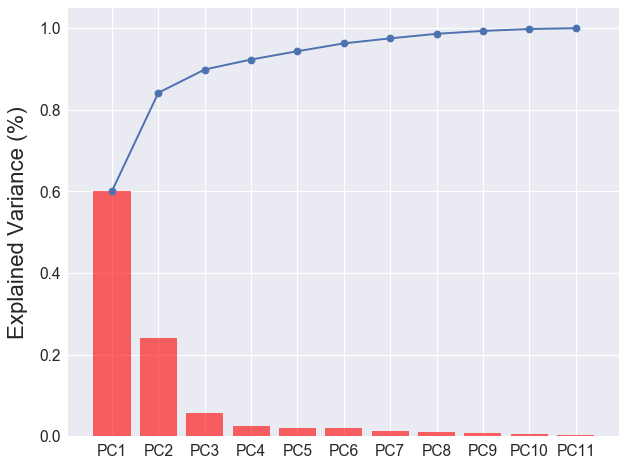

In [84]:
# Graph of prop of variance explained and cumulative prop
objects = ('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11')
y_pos = np.arange(len(objects))
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
ax = fig.add_subplot(111)
ax.bar(y_pos, percent_var, align='center', alpha=0.6, color='r')
ax.plot(y_pos, cum_var, '-o')
plt.xticks(y_pos, objects, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Explained Variance (%)', fontsize=20, labelpad=10)

fig.tight_layout()
plt.show()

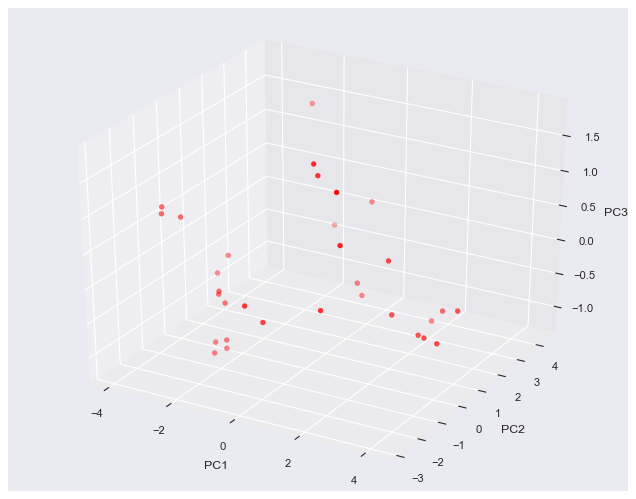

In [101]:
# Dimensionally reduce data using first three PCs
Z_reduced = Z[:, 0:3]

# Plot 3d scatter of Z_reduced
x = Z_reduced[:, 0]
y = Z_reduced[:, 1]
z = Z_reduced[:, 2]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='w')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, zdir='z', c= 'red')
ax.set_xlabel('PC1', labelpad=10)
ax.set_ylabel('PC2', labelpad=10)
ax.set_zlabel('PC3', labelpad=10)

plt.show()

In [98]:
# Conduct cluster analysis on Z_reduced using k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(Z_reduced)
y_kmeans = kmeans.predict(Z_reduced)

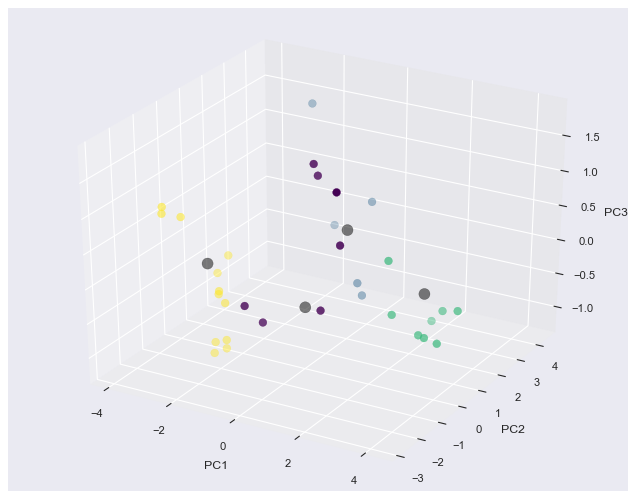

In [105]:
# Plot 3d scatter of Z_reduced with k-means
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y,  z, c=y_kmeans, s=50, cmap='viridis')
ax.set_xlabel('PC1', labelpad=10)
ax.set_ylabel('PC2', labelpad=10)
ax.set_zlabel('PC3', labelpad=10)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.show()

In [120]:
# Conduct PC regression with Horsepower as dependent variable

# Make y array and new data matrix
y = df.hp
X_new = df.drop(['hp','model'], axis=1).astype(float)

# Perform PCA
pca_new = PCA()
Z_new = pca.fit_transform(scale(X_new))

In [123]:
# Perform 5-fold cross-validation to see how it influences the MSE
n = len(Z) # number of samples

# KFold provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds with shuffling
kf_5 = KFold(5, shuffle=True, random_state=1)

# Set up ordinary least squares linear regression 
regr = LinearRegression()

# Array to store mean squared errors (MSE)
mse = []

# Calculate average MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_5, scoring='neg_mean_squared_error').mean()
mse.append(score)

In [125]:
# Calculate average MSE using cross-validation for the 10 principle components
# adding one more component with each iteration
for i in np.arange(1, 11):
    # Find average MSE and add to mse array
    score = -1*cross_val_score(regr, Z_new[:,:i], y.ravel(), cv=kf_5, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
    # Find accuracy and print
    score2 = cross_val_score(regr, Z_new[:,:i], y.ravel(), cv=kf_5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))

Accuracy: 0.63 (+/- 0.37)
Accuracy: 0.70 (+/- 0.59)
Accuracy: 0.69 (+/- 0.57)
Accuracy: 0.66 (+/- 0.64)
Accuracy: 0.65 (+/- 0.64)
Accuracy: 0.68 (+/- 0.51)
Accuracy: 0.61 (+/- 0.73)
Accuracy: 0.64 (+/- 0.68)
Accuracy: 0.59 (+/- 0.61)
Accuracy: 0.59 (+/- 0.73)


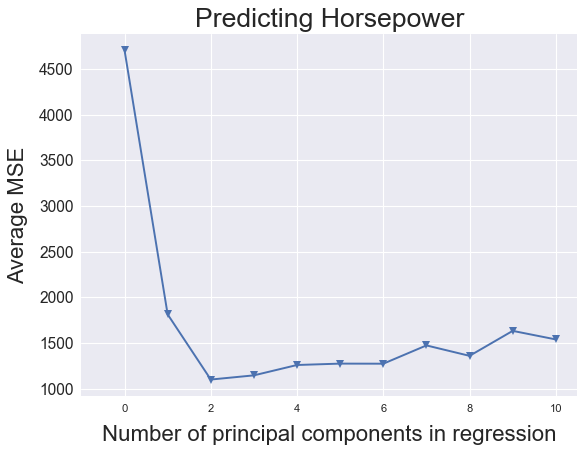

In [130]:
# Plot average MSEs against the number of principal components
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression', fontsize=20, labelpad=10)
plt.ylabel('Average MSE', fontsize=20, labelpad=10)
plt.title('Predicting Horsepower', fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin=-1)
plt.show()

# Interpretation: smallest cross validation error occurs when 2 principal components used

In [132]:
# Find cumulative amount of variance expained from pca_new
np.cumsum(np.round(pca_new.explained_variance_ratio_, decimals=4)*100)

array([  59.36,   84.  ,   90.15,   92.84,   94.96,   96.65,   98.  ,
         99.16,   99.72,  100.  ])

In [133]:
# Apply to training data

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.5, random_state=1)

# Perform PCA on training data to evaluate test set performance
pca_train = PCA()

Accuracy: 0.56 (+/- 0.26)
Accuracy: 0.54 (+/- 0.72)
Accuracy: 0.54 (+/- 0.33)
Accuracy: 0.56 (+/- 0.30)
Accuracy: 0.42 (+/- 0.57)
Accuracy: 0.05 (+/- 1.22)
Accuracy: 0.07 (+/- 1.21)
Accuracy: -1.23 (+/- 5.24)
Accuracy: -1.50 (+/- 0.91)
Accuracy: -0.78 (+/- 1.04)


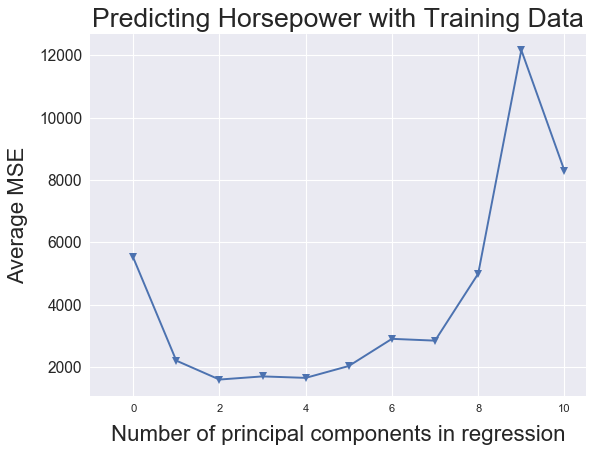

In [142]:
# Verify number of PCs with smallest MSE on X_train
Z_train = pca_train.fit_transform(scale(X_train))
n = len(Z_train)

# Prepare 3-fold CV, with shuffle
kf_3 = KFold(3, shuffle=True, random_state=1)
mse = []

# Calculate average MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_3, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate average MSEs using CV for the 10 principle components, adding one component at the time.
for i in np.arange(1, 11):
    score = -1*cross_val_score(regr, Z_train[:,:i], y_train.ravel(), cv=kf_3, scoring='neg_mean_squared_error').mean()
    score2 = cross_val_score(regr, Z_train[:,:i], y_train.ravel(), cv=kf_3)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))
    mse.append(score)
    
# Plot average MSEs against the number of principal components
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression', fontsize=20, labelpad=10)
plt.ylabel('Average MSE', fontsize=20, labelpad=10)
plt.title('Predicting Horsepower with Training Data', fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin=-1)
plt.show()

# Interpretation: smallest cross validation error still occurs when 2 principal components used

In [147]:
# Apply to test data

# Dimensionally reduce training data using 1st 2 PCs
Z_train_reduced = Z_train[:,:2]
# Dimensionally reduce test data using 1st 2 PCs obtained from PCA of training data
Z_test_reduced = pca_train.transform(scale(X_test))[:,:2]

# Train regression model on training data
regr = LinearRegression()
regr.fit(Z_train_reduced, y_train)

# Use model to predict values from test data
pred = regr.predict(Z_test_reduced)
print("Predictions:", np.asarray(pred).round(0))
print("Actual:", np.asarray(y_test))
mean_squared_error(y_test, pred)

Predictions: [ 115.  119.  201.   89.  245.   75.  209.  255.   66.  249.  206.  156.
   84.  149.  202.  101.]
Actual: [113 110 150  52 245  66 150 264  65 205 175 123  97  91 175  93]


1001.1129246026541

In [160]:
# Finding SPE (method 1)
# SPE = xV_0V_0'x'
# V_0 is the null space of the zero singular values (contains the 8 eliminated PCs)
# x refers to test data ()

x = scale(X_test)
V_0 = pca_train.components_[2:, :].T
print(V_0.shape)
print(x.shape)
SPE2 = np.matmul(V_0.T, x.T) 
SPE1 = np.matmul(V_0, SPE2)
SPE = np.matmul(x, SPE1)
print(SPE.shape)
#print(SPE)

# Diagonals correspond to SPEs for each test sample
print(SPE.diagonal())

(10, 8)
(16, 10)
(16, 16)
[ 2.19065913  0.47900586  0.70362418  1.2561181   2.40037878  0.99105866
  1.06877512  1.6352234   1.1020938   2.84388742  0.86548879  5.93713565
  0.96608989  2.19181728  0.88715357  1.70900947]


In [159]:
# Finding SPE (method 2)
# SPE = inner product of residual vector (e)
# e = X_test - predicted X from PCs
X_test_pred = np.matmul(Z_test_reduced, pca_train.components_[:2, :]) #predicted X from PCs
e = scale(X_test) - x_hat_new
SPE = np.matmul(e_new, e_new.T)
# Diagonals correspond to SPEs for each test sample
print(SPE.diagonal())

# Use method 2 to find SPE for first sample
x_new = scale(X_test, axis=0, with_mean=True, with_std=True, copy=True)[0, :]
P = pca_train.components_[:2, :].T
t_new = np.matmul(x_new, P)
x_hat_new = np.matmul(t_new, P.T)
e_new = x_new - x_hat_new
SPE_one = np.matmul(e_new, e_new.T)
print(SPE_one)

[ 2.19065913  0.47900586  0.70362418  1.2561181   2.40037878  0.99105866
  1.06877512  1.6352234   1.1020938   2.84388742  0.86548879  5.93713565
  0.96608989  2.19181728  0.88715357  1.70900947]
2.19065913182
